# PyVRP: Hybrid Genetic Search for the VRPTW
This notebook contains an example of how to use the PyVRP library to solve the Vehicle Routing Problem with Time Windows (VRPTW).

### Imports

In [1]:
import sys
import numpy as np
from typing import Callable, Dict, List, Optional
from functools import partial
from pathlib import Path
from IPython.display import display

from pyvrp import (
    GeneticAlgorithm,
    GeneticAlgorithmParams,
    PenaltyManager,
    Population,
    ProblemData,
    Result,
    XorShift128,
    diagnostics,
    plotting,
    read,
)
from pyvrp.crossover import selective_route_exchange
from pyvrp.diversity import broken_pairs_distance
from pyvrp.educate import NODE_OPERATORS, ROUTE_OPERATORS, LocalSearch
from pyvrp.stop import MaxIterations, MaxRuntime, StoppingCriterion

import vrplib

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Make sure data_dir exists
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

### Read instance and convert to ProblemData

In [3]:
# Create data directory
solomon_dir = data_dir / "vrptw" / "Solomon"
solomon_dir.mkdir(parents=True, exist_ok=True)

# Download an instance and best known solution
instance_name = "RC208"
instance_filename = solomon_dir / f"{instance_name}.vrp"
if not instance_filename.exists():
    vrplib.download_instance(instance_name, instance_filename)
instance_bks_filename = solomon_dir / f"{instance_name}.sol"
if not instance_bks_filename.exists():
    vrplib.download_solution(instance_name, instance_bks_filename)

# Load instance and convert to ProblemData, scaling by 10 to truncate at 1 decimal
instance = read(
    instance_filename, instance_format="solomon", round_func="trunc1"
)
instance_bks = vrplib.read_solution(instance_bks_filename)

### Plot instance data

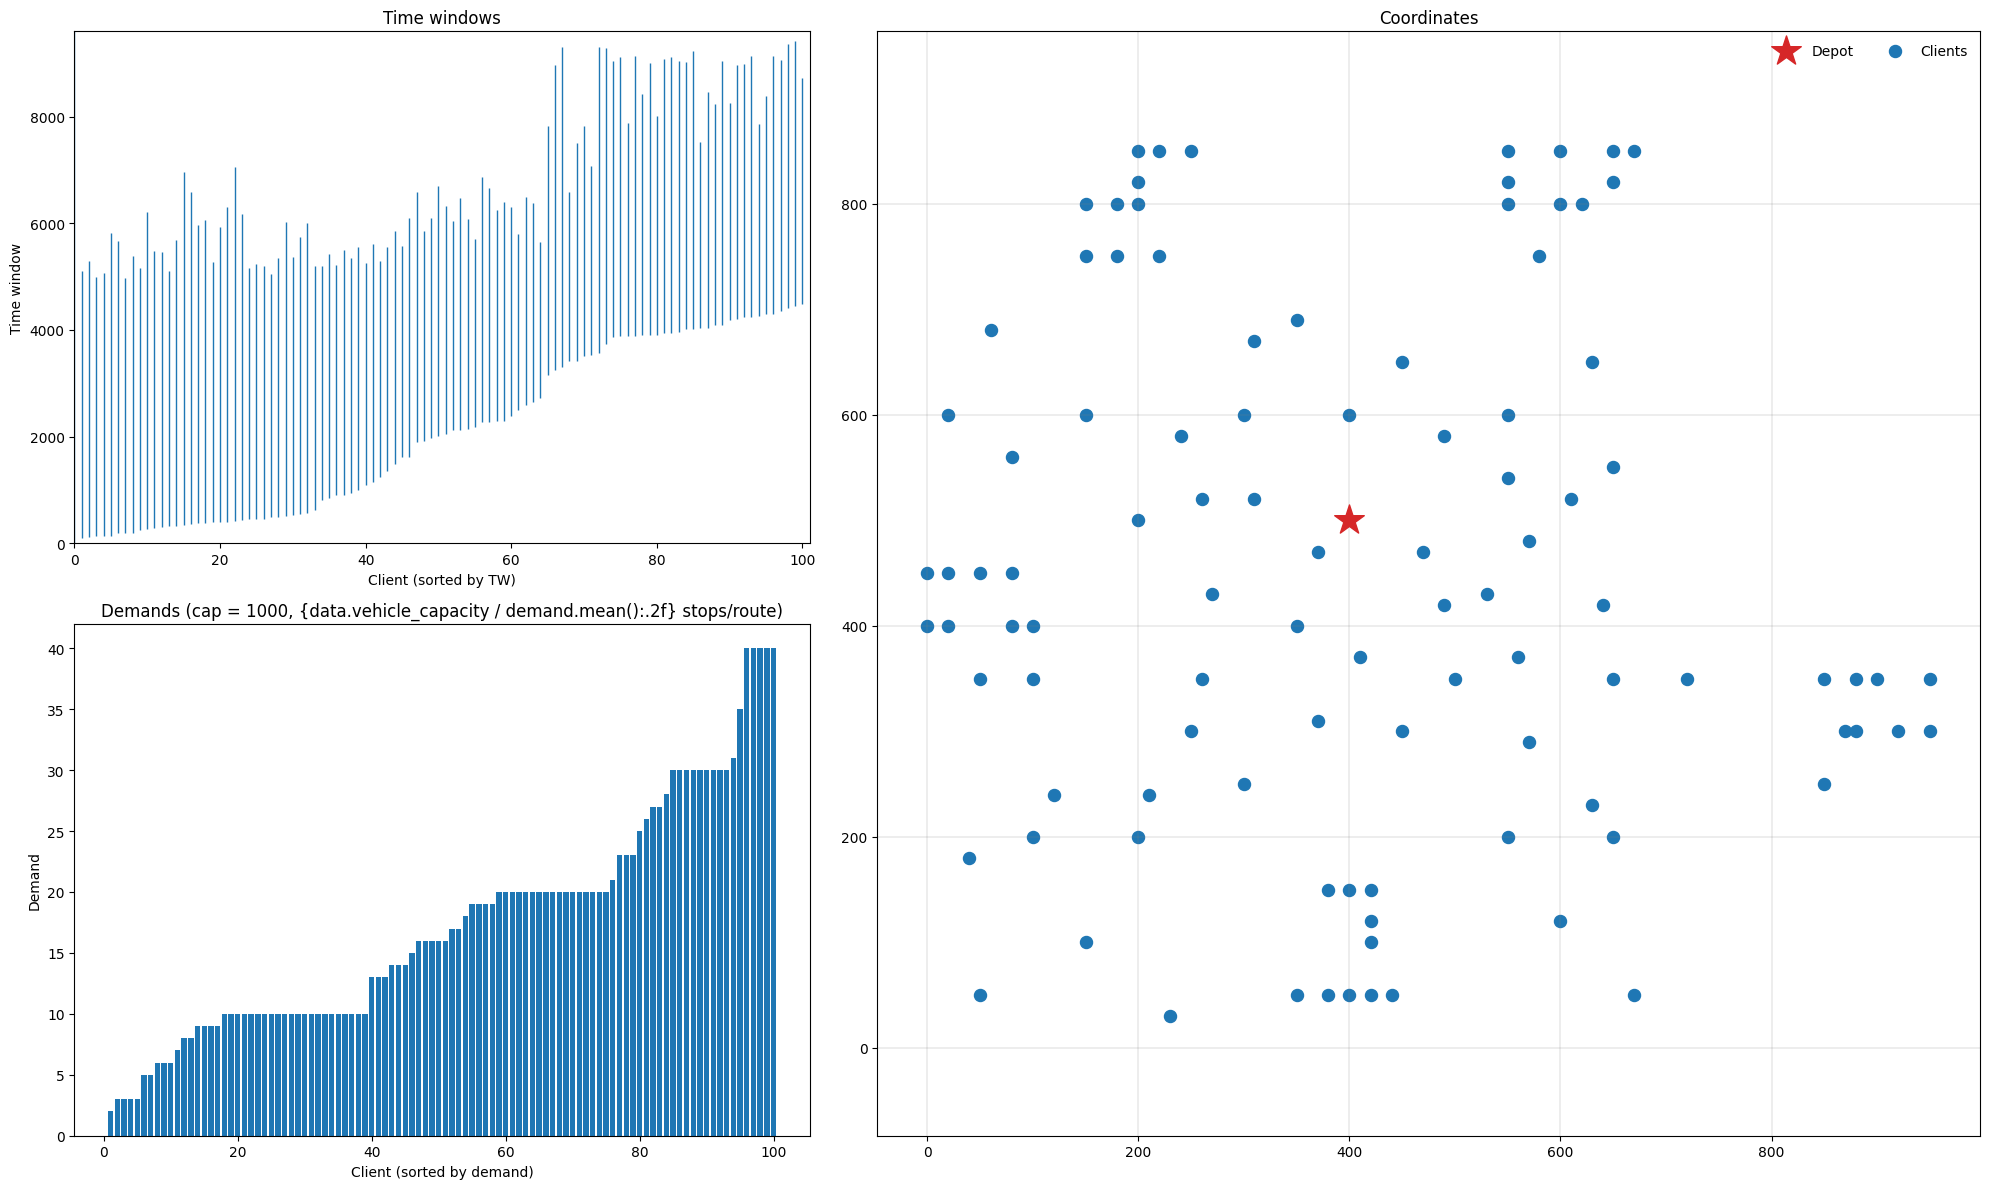

In [4]:
plotting.plot_instance(instance)

### Configure Hybrid Genetic Search

In [5]:
def solve(
    data: ProblemData,
    seed: int,
    max_runtime: Optional[float] = None,
    max_iterations: Optional[int] = None,
    **kwargs,
):
    rng = XorShift128(seed=seed)
    pen_manager = PenaltyManager(data.vehicle_capacity)
    pop = Population(data, pen_manager, rng, broken_pairs_distance)
    ls = LocalSearch(data, pen_manager, rng)

    node_ops = [node_op(data, pen_manager) for node_op in NODE_OPERATORS]

    for op in node_ops:
        ls.add_node_operator(op)

    route_ops = [route_op(data, pen_manager) for route_op in ROUTE_OPERATORS]

    for op in route_ops:
        ls.add_route_operator(op)

    crossover_op = selective_route_exchange
    ga_params = GeneticAlgorithmParams(collect_statistics=True)
    algo = GeneticAlgorithm(
        data, pen_manager, rng, pop, ls, crossover_op, ga_params
    )

    if max_runtime is not None:
        stop: StoppingCriterion = MaxRuntime(max_runtime)
    else:
        assert max_iterations is not None
        stop = MaxIterations(max_iterations)

    return algo.run(stop)

### Set arguments and run algorithm

In [6]:
args = {"seed": 42, "max_runtime": 10}
result = solve(instance, **args)
solution = result.best
# Note the scaling of the solution cost
print(
    f"Total cost of solution: {solution.cost() / 10}, BKS = {instance_bks['cost']}"
)

Total cost of solution: 779.6, BKS = 776.1


### Plot results

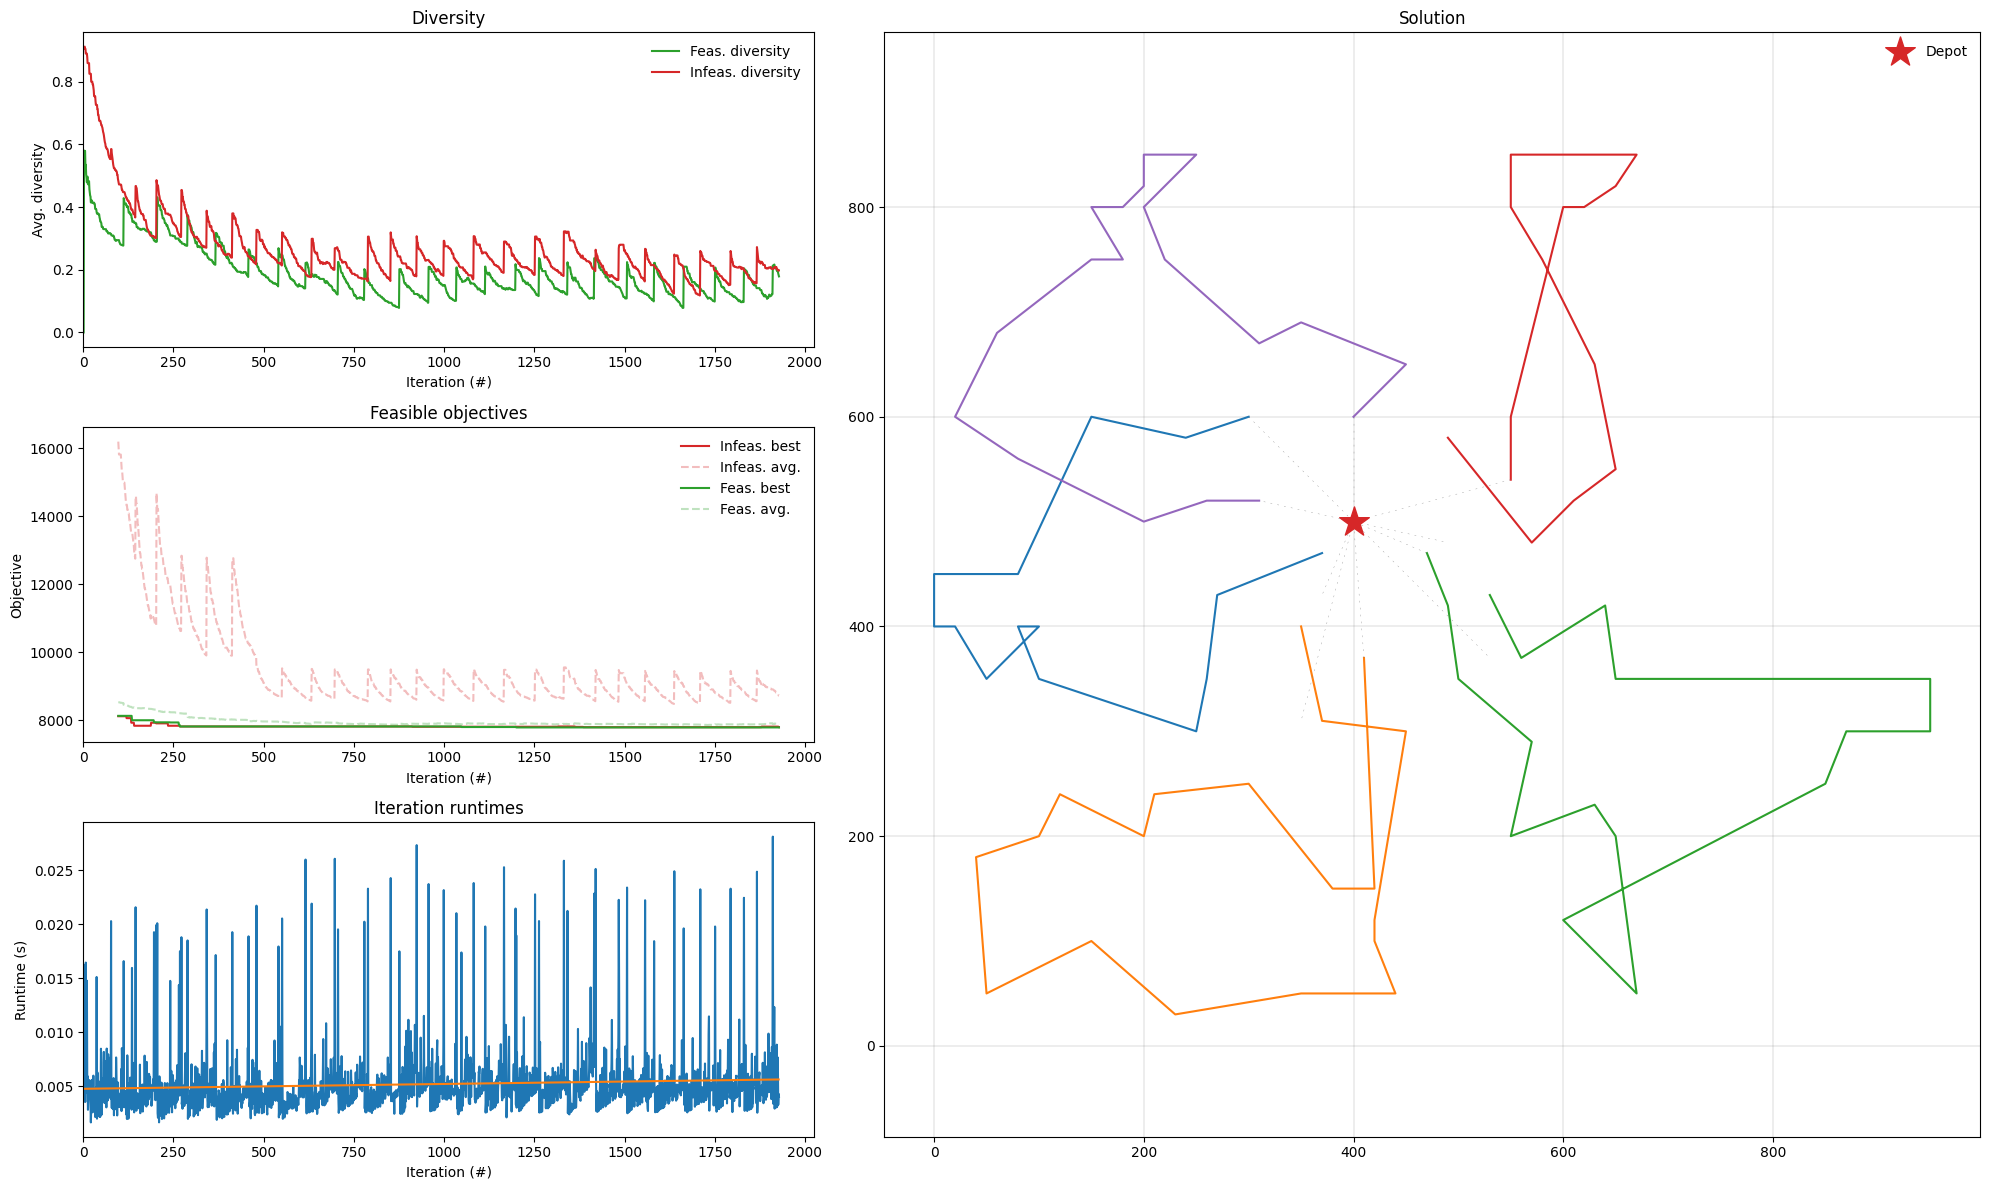

In [7]:
plotting.plot_result(result, instance)

### Inspect route statistics

In [8]:
route_stats = diagnostics.get_all_route_statistics(solution, instance)
# Verify that cost is equal to total distance
assert sum([s.distance for s in route_stats]) == solution.cost()

route_stats_df = pd.DataFrame(route_stats)
display(route_stats_df.head())

,distance,start_time,end_time,duration,timewarp,wait_time,service_time,num_stops,total_demand,fillrate,is_feasible,is_empty
0,1249,0,5879,5879,0,2930,1700,17,285,0.285,True,False
1,1941,0,7043,7043,0,2802,2300,23,432,0.432,True,False
2,1895,0,6857,6857,0,2662,2300,23,358,0.358,True,False
3,1307,0,6233,6233,0,3226,1700,17,300,0.300,True,False
4,1404,0,5389,5389,0,1985,2000,20,349,0.349,True,False


### Plot route schedules

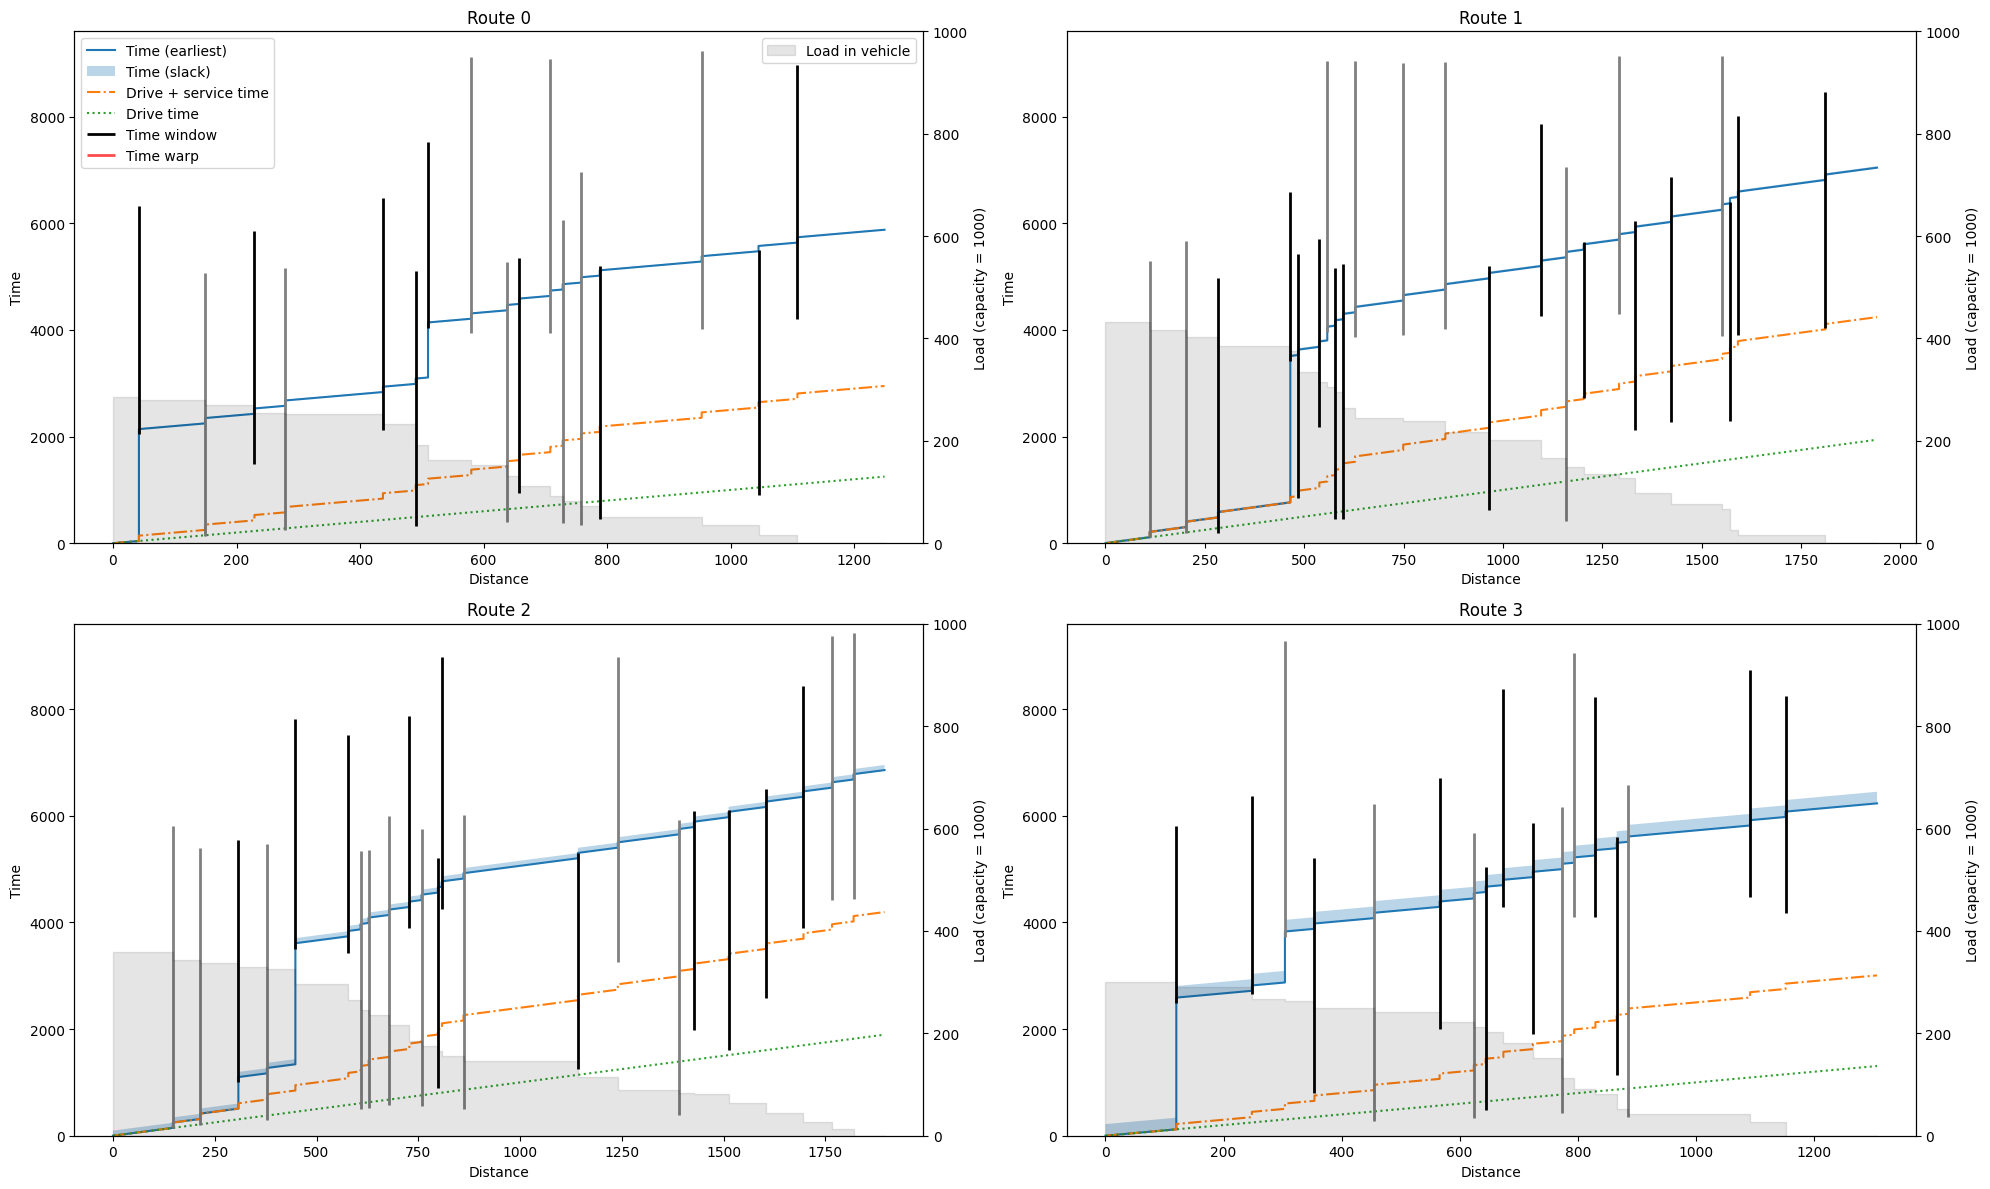

In [9]:
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
routes = solution.get_routes()
for i, (ax, route) in enumerate(zip(axarr.reshape(-1), routes)):
    plotting.plot_route_schedule(
        instance, route, title=f"Route {i}", ax=ax, legend=i == 0
    )
fig.tight_layout()

## Running larger instances

### Gehring & Homberger instance

Total cost of solution: 27948.0, BKS = 25797.5


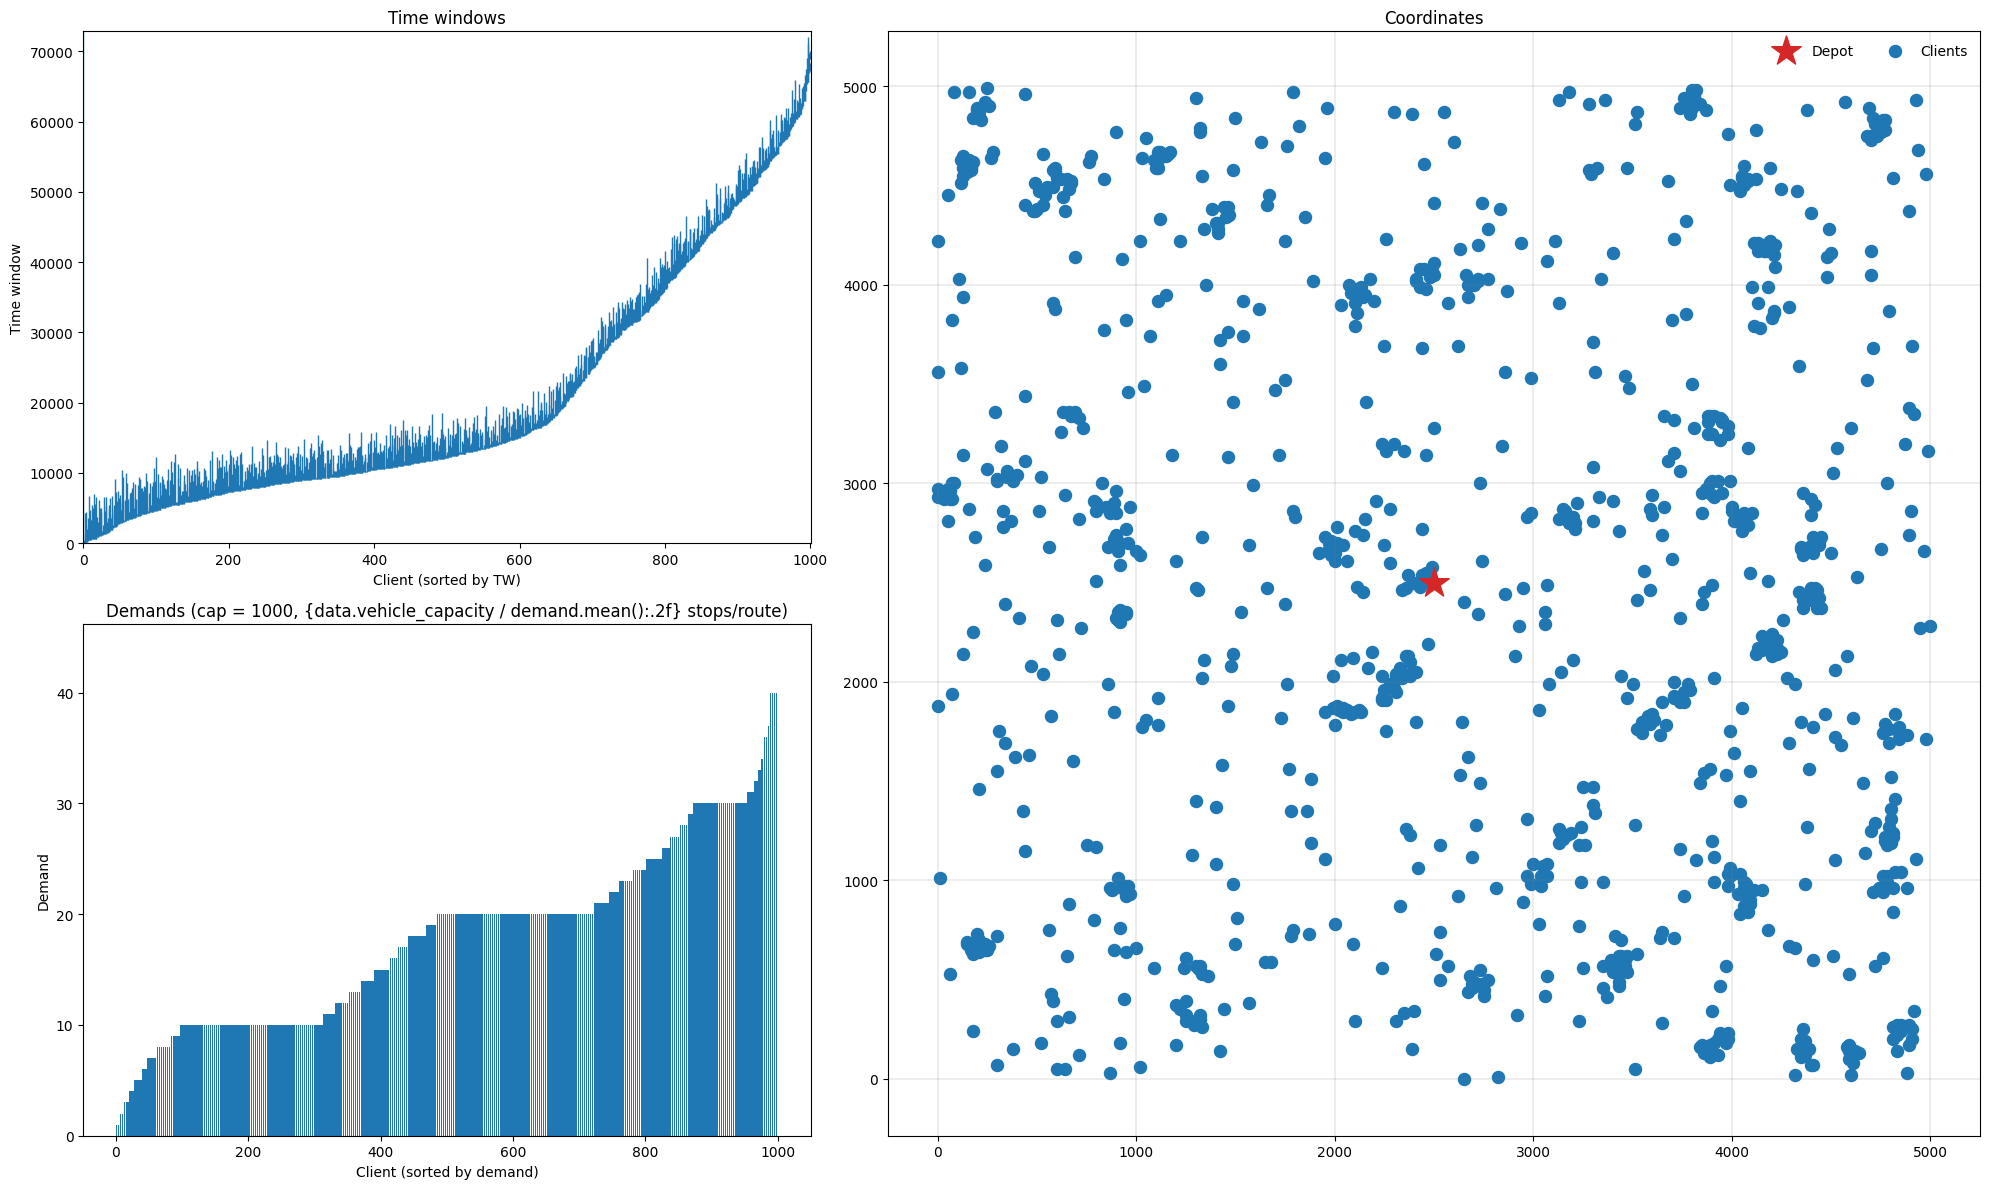

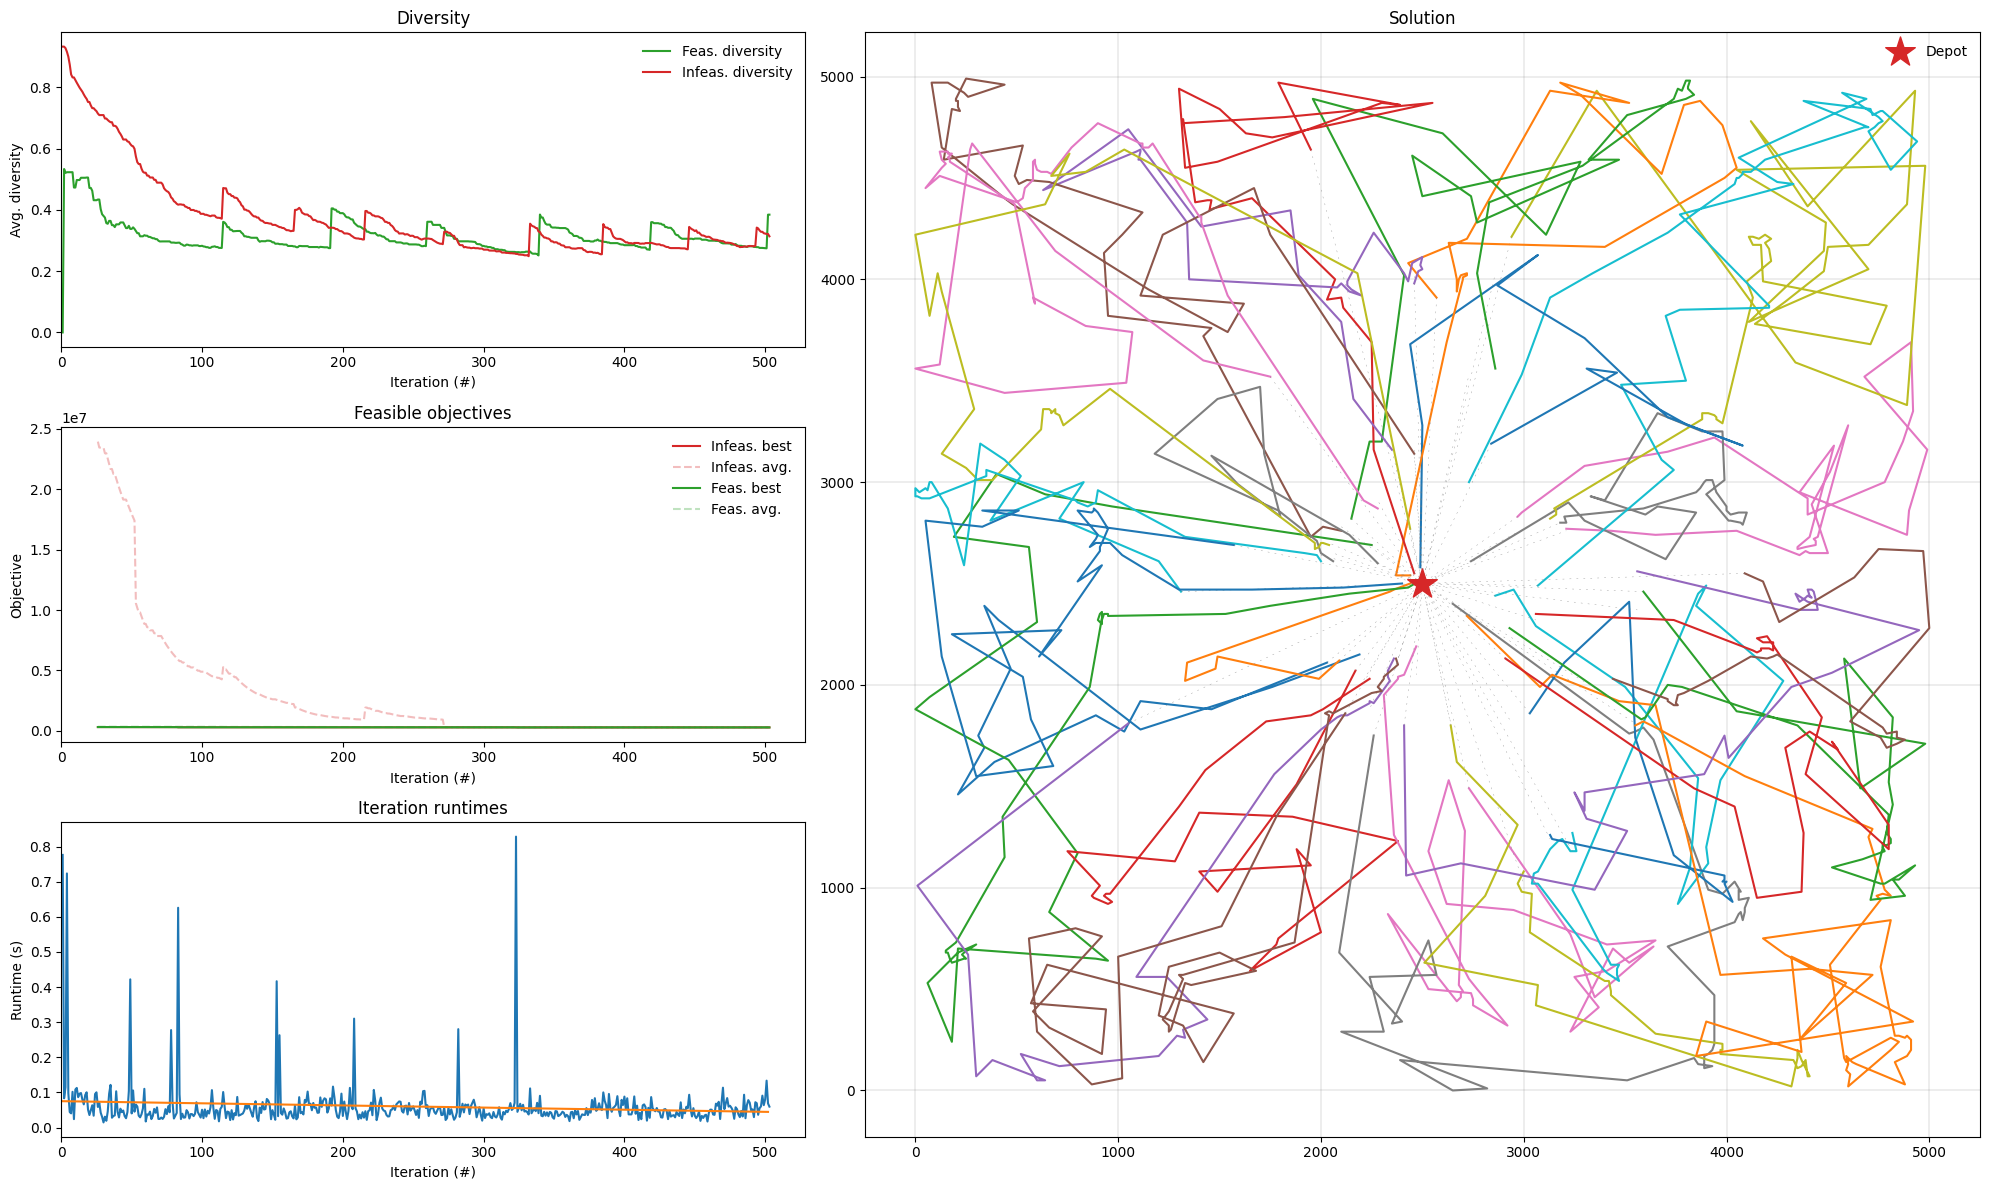

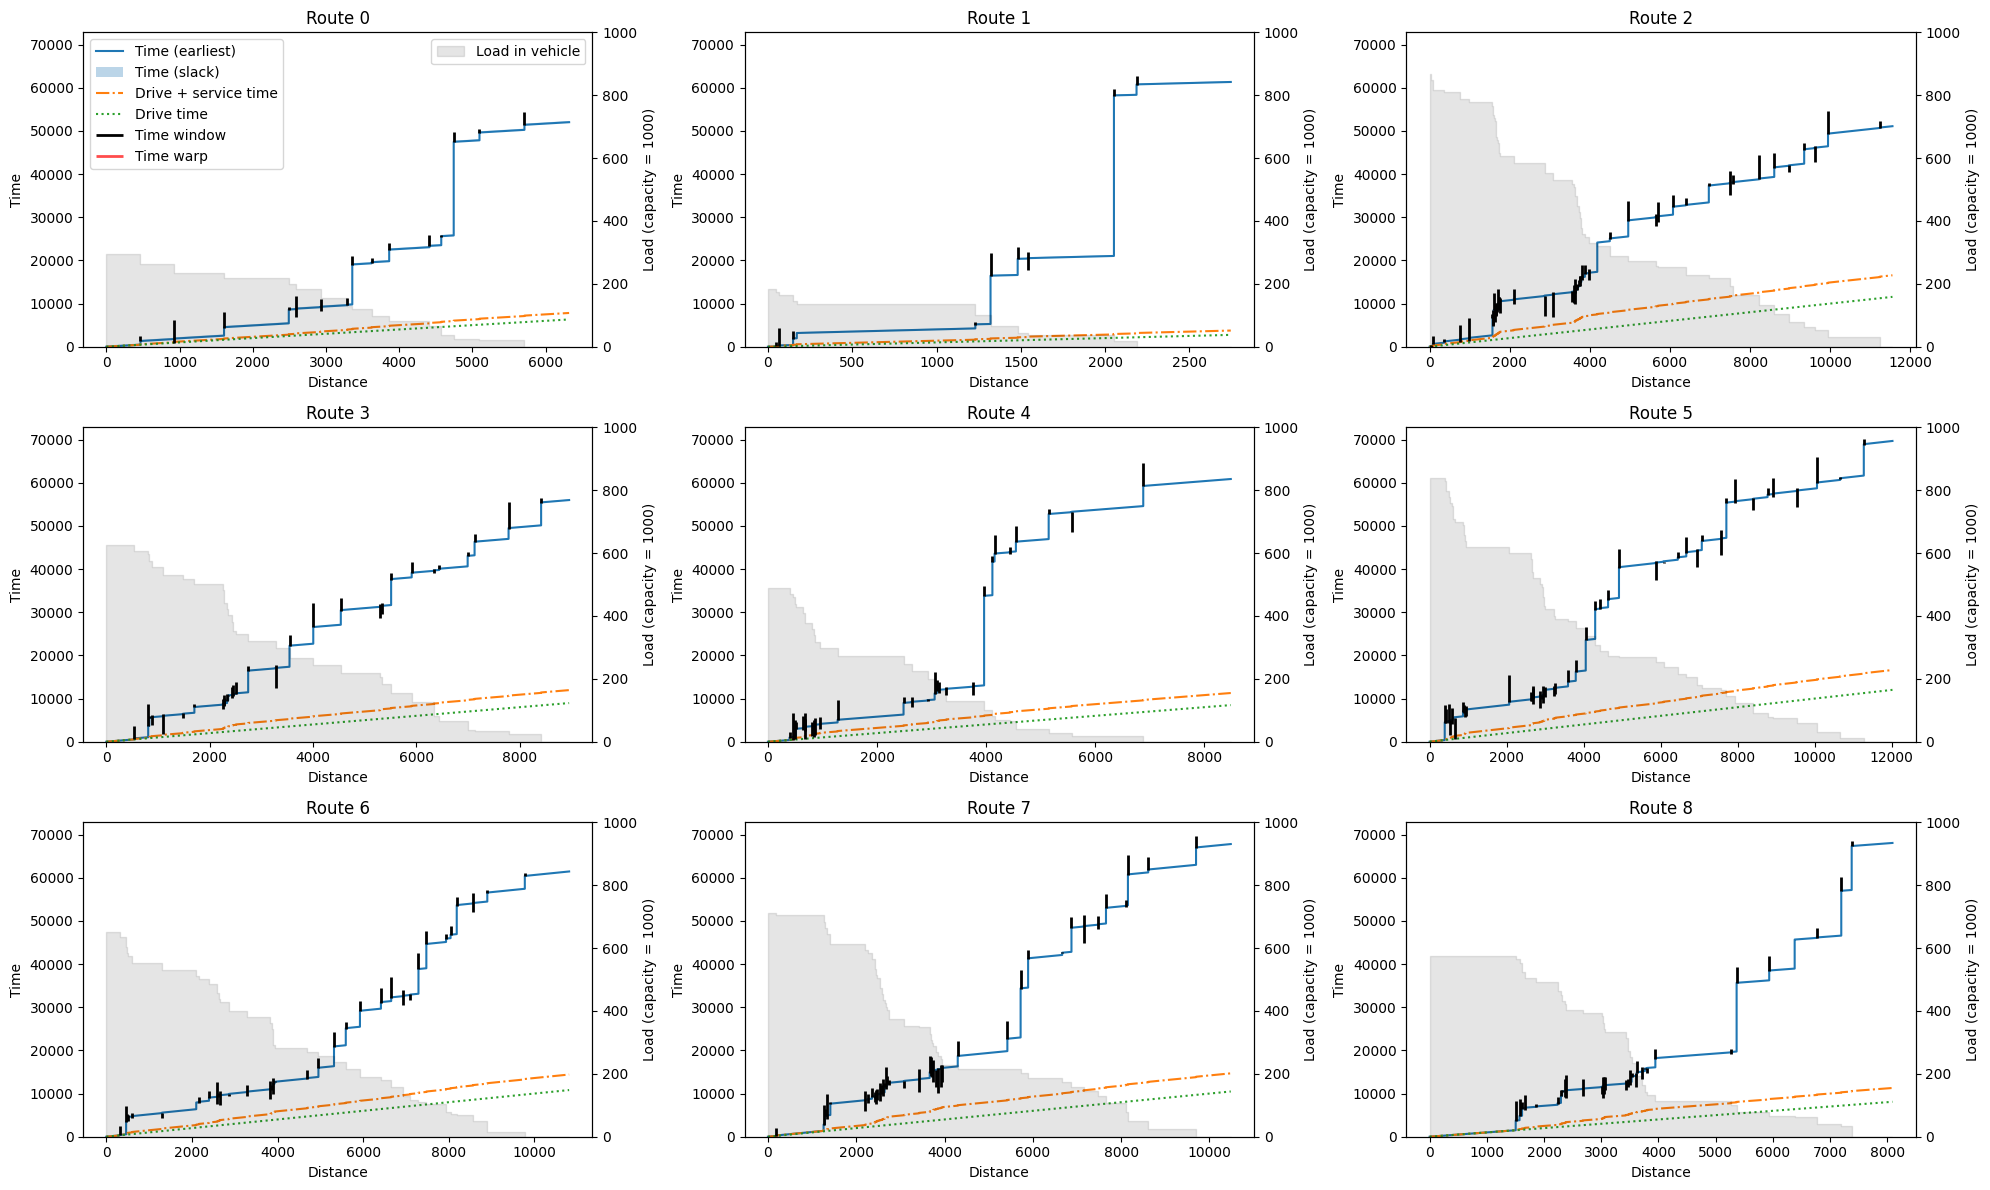

In [10]:
# Create directory, download instance and best known solution
gh_dir = data_dir / "vrptw" / "GH"
gh_dir.mkdir(parents=True, exist_ok=True)

# Download an instance and best known solution
instance_name_gh = "RC2_10_5"
instance_filename_gh = gh_dir / f"{instance_name_gh}.vrp"
if not instance_filename_gh.exists():
    vrplib.download_instance(instance_name_gh, instance_filename_gh)
instance_bks_filename_gh = gh_dir / f"{instance_name_gh}.sol"
if not instance_bks_filename_gh.exists():
    vrplib.download_solution(instance_name_gh, instance_bks_filename_gh)

# Read, convert and plot instance
instance_gh = read(
    instance_filename_gh, instance_format="solomon", round_func="trunc1"
)
instance_gh_bks = vrplib.read_solution(instance_bks_filename_gh)
plotting.plot_instance(instance_gh)

# Run HGS algorithm and plot result
args = {"seed": 42, "max_runtime": 30}
result_gh = solve(instance_gh, **args)
print(
    f"Total cost of solution: {result_gh.best.cost() / 10}, BKS = {instance_gh_bks['cost']}"
)
plotting.plot_result(result_gh, instance_gh)

# Plot some route schedules
fig, axarr = plt.subplots(3, 3, figsize=(20, 12))
for i, (ax, route) in enumerate(
    zip(axarr.reshape(-1), result_gh.best.get_routes())
):
    plotting.plot_route_schedule(
        instance_gh, route, title=f"Route {i}", ax=ax, legend=i == 0
    )
fig.tight_layout()

### ORTEC instance (from EURO Meets NeurIPS 2022 Competition)

Total cost of solution: 267557


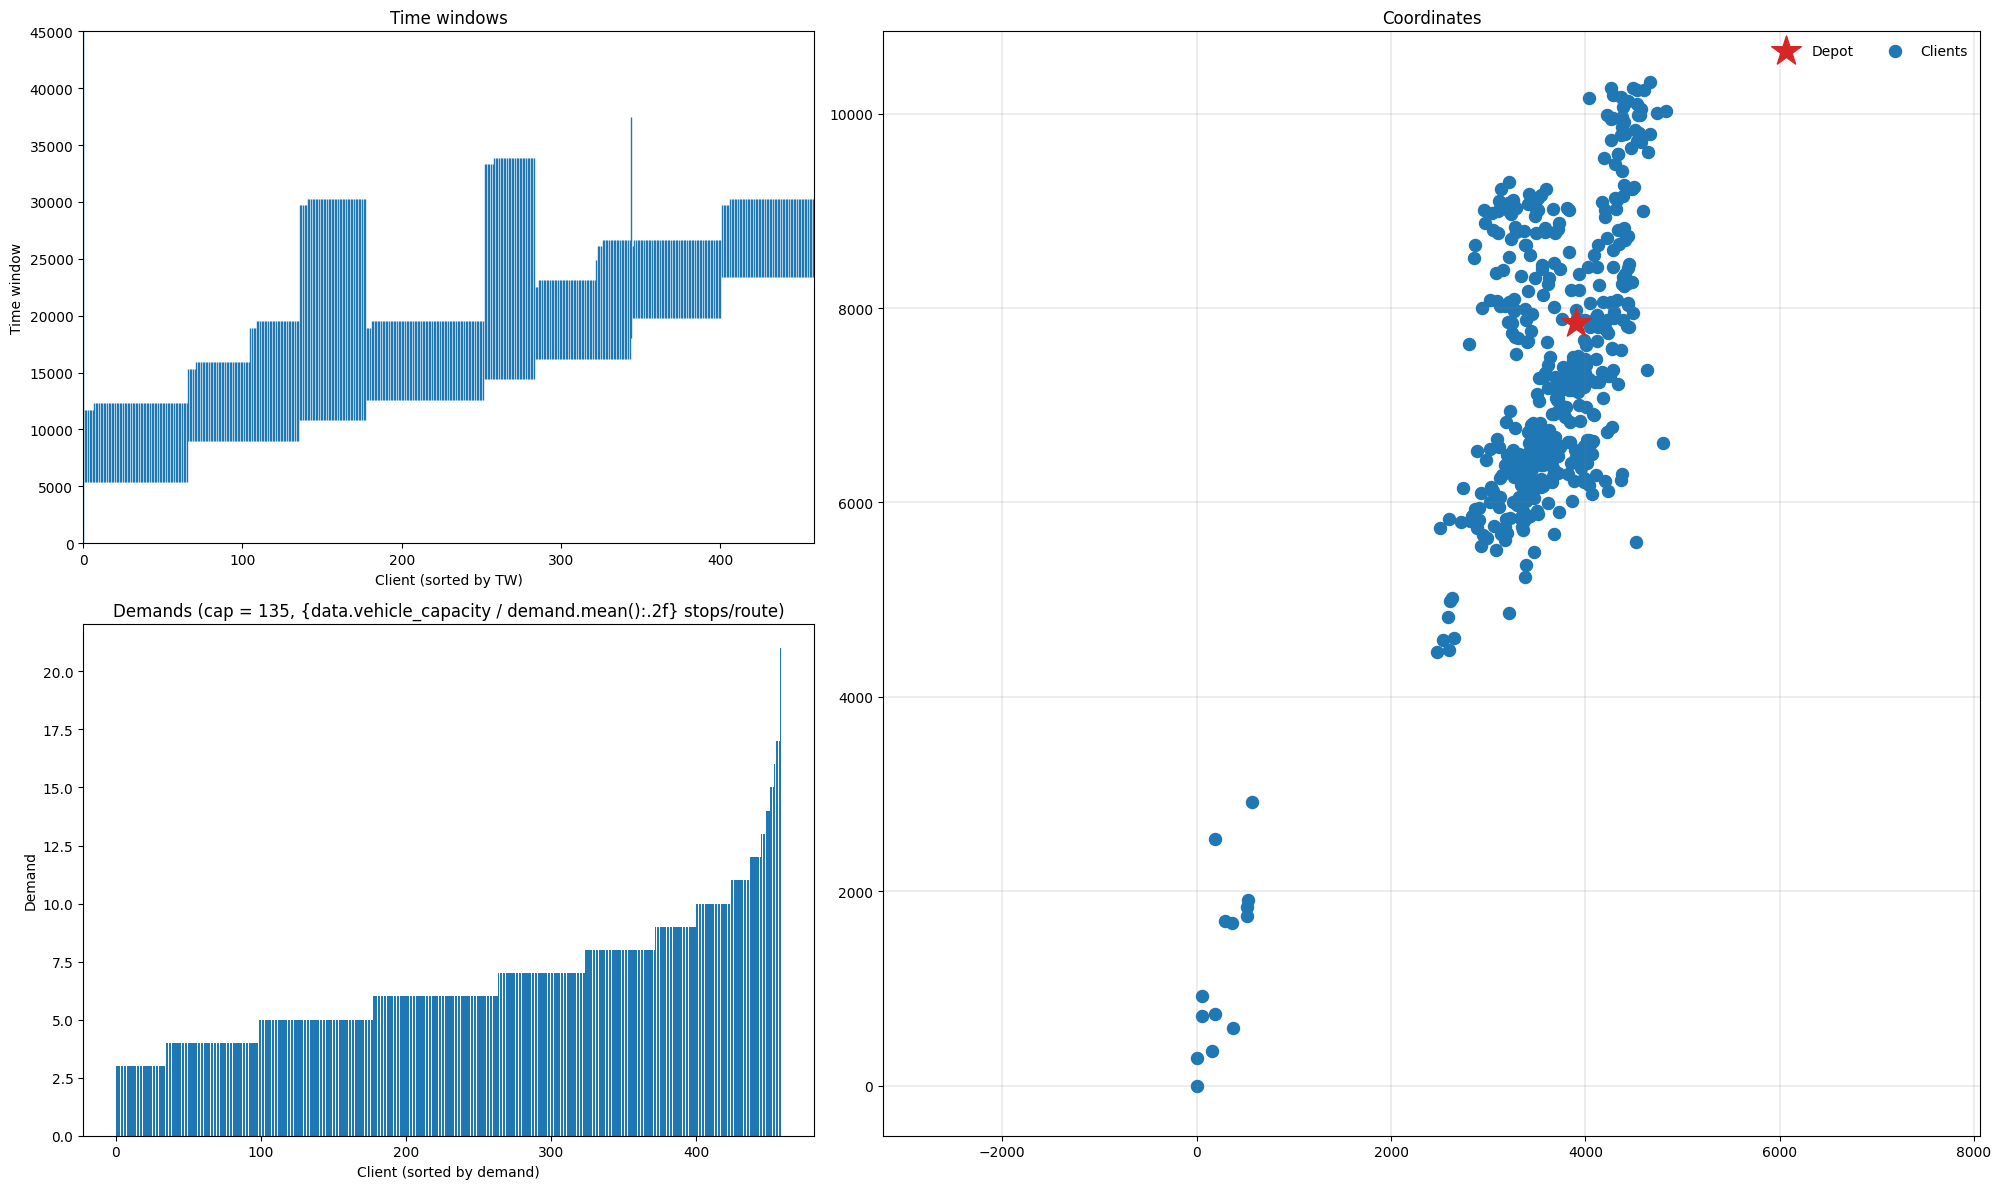

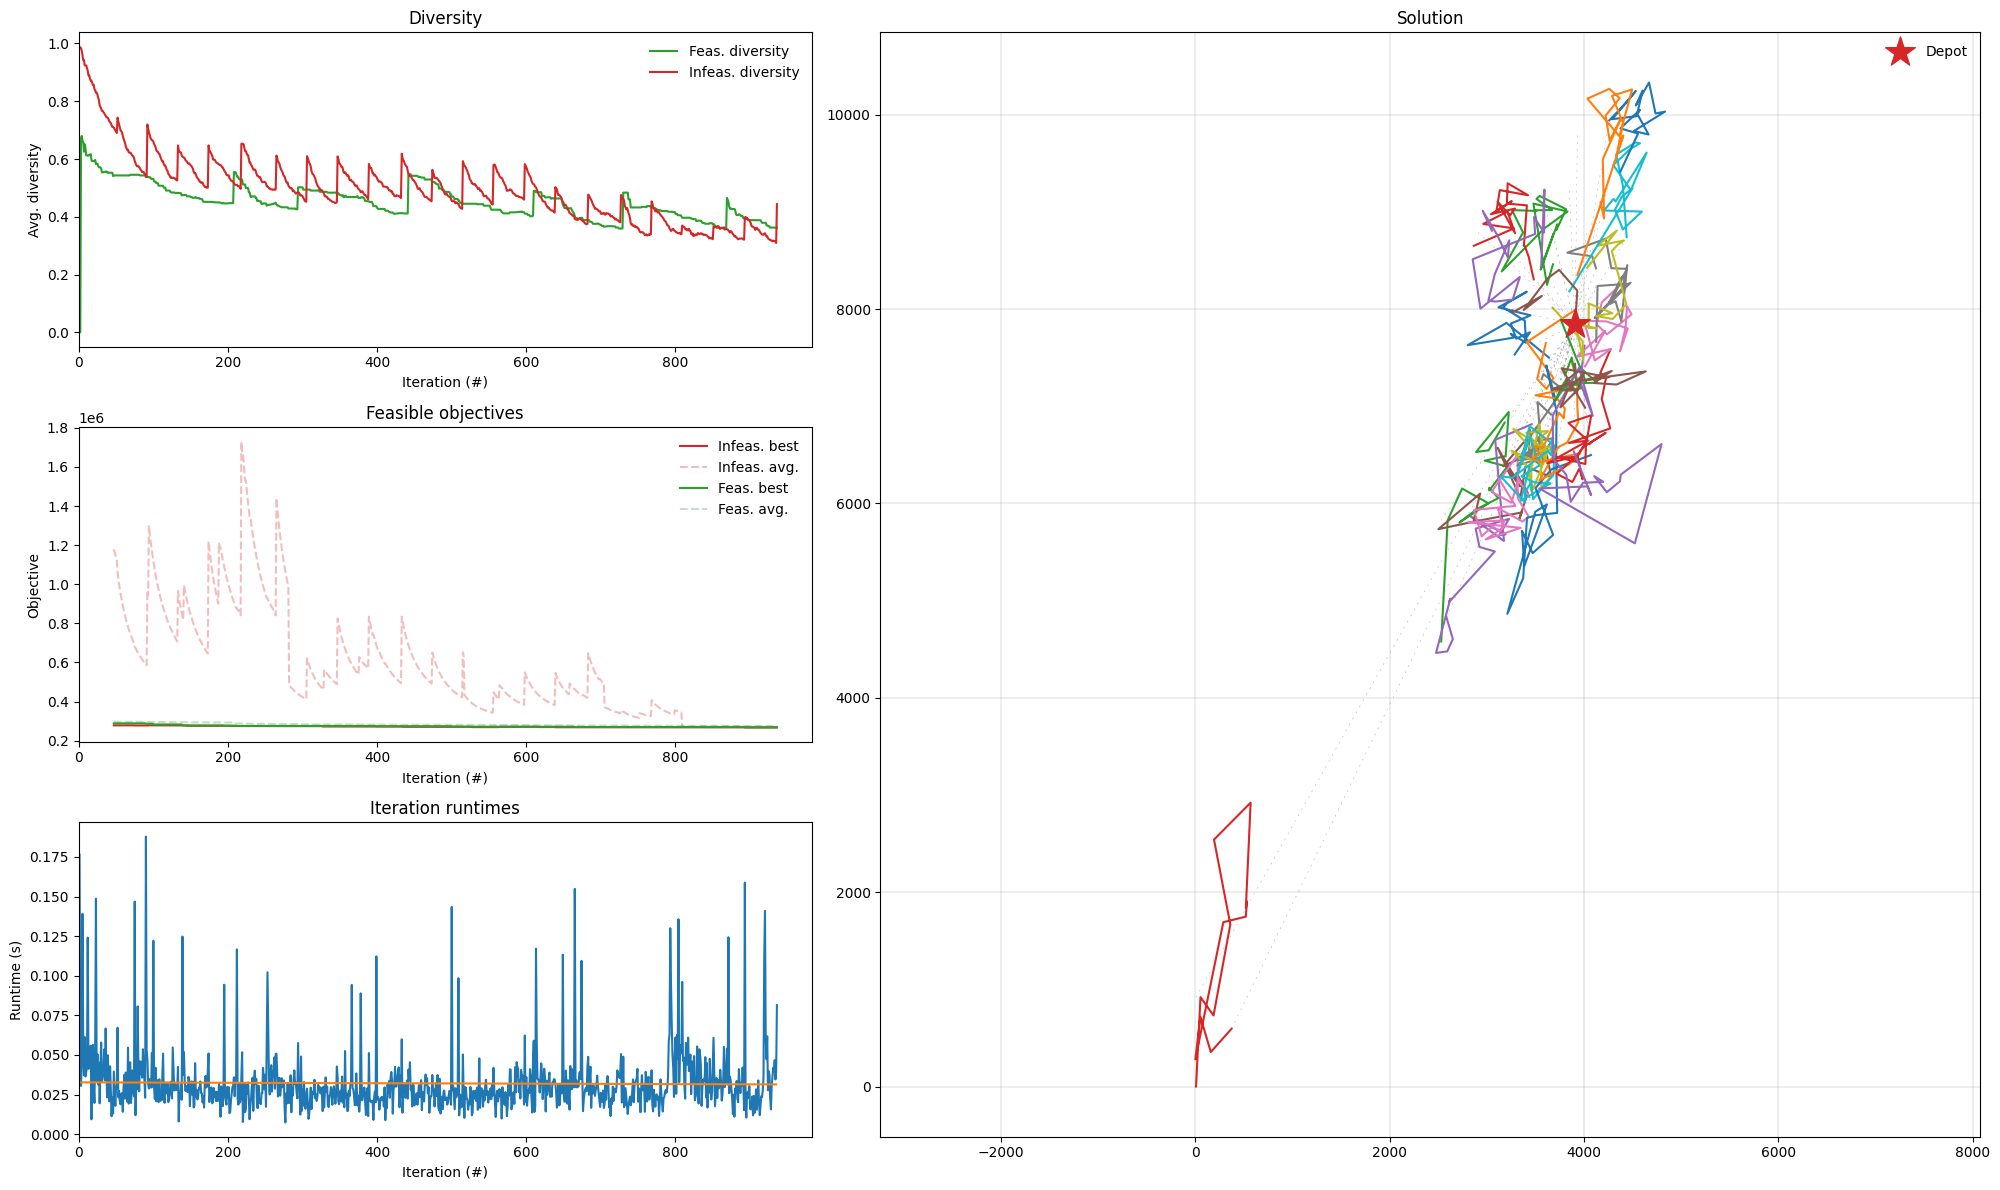

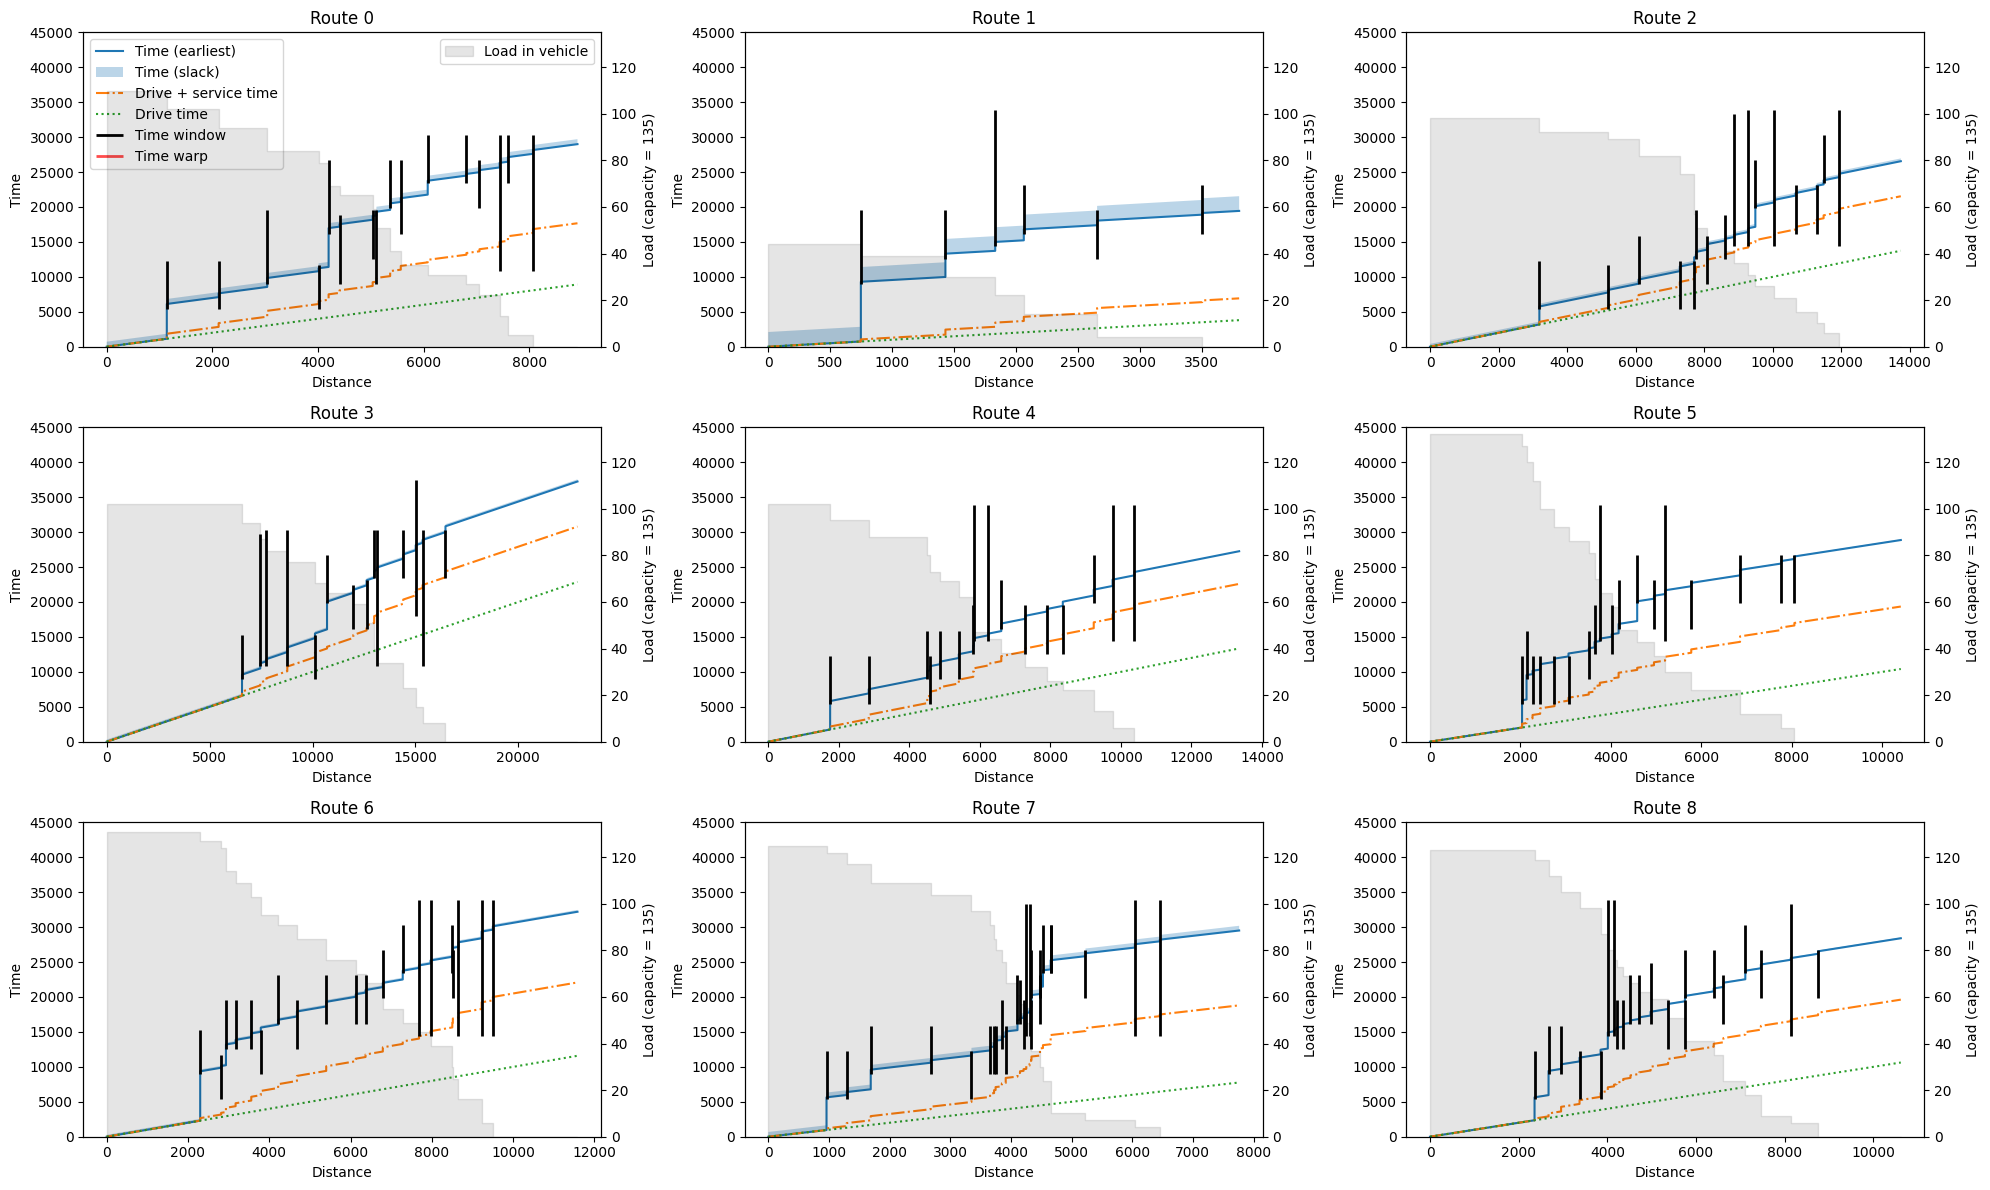

In [11]:
# Create directory and download instance
ortec_dir = data_dir / "vrptw" / "ORTEC"
ortec_dir.mkdir(parents=True, exist_ok=True)

# Read, convert and plot instance
# # instance_name_ortec = "ORTEC-VRPTW-ASYM-00c5356f-d1-n258-k12"
instance_name_ortec = "ORTEC-VRPTW-ASYM-0bdff870-d1-n458-k35"
instance_filename_ortec = ortec_dir / f"{instance_name_ortec}.txt"
download_url = f"https://github.com/ortec/euro-neurips-vrp-2022-quickstart/raw/main/instances/{instance_name_ortec}.txt"
if not instance_filename_ortec.exists():
    ! wget -q -O {instance_filename_ortec} {download_url}

# Note: no need to round as these instances have explicit integer distance matrices
instance_ortec = read(instance_filename_ortec, instance_format="vrplib")
plotting.plot_instance(instance_ortec)

# Run HGS algorithm and plot result
args = {"seed": 42, "max_runtime": 30}
result_ortec = solve(instance_ortec, **args)
print(f"Total cost of solution: {result_ortec.best.cost()}")
plotting.plot_result(result_ortec, instance_ortec)

# Plot some route schedules
fig, axarr = plt.subplots(3, 3, figsize=(20, 12))
for i, (ax, route) in enumerate(
    zip(axarr.reshape(-1), result_ortec.best.get_routes())
):
    plotting.plot_route_schedule(
        instance_ortec, route, title=f"Route {i}", ax=ax, legend=i == 0
    )
fig.tight_layout()